


# MAIS 202 Final Project 


Import Libraries

In [1]:
!pip install biopython

     |████████████████████████████████| 2.3MB 7.2MB/s 


In [2]:
# Libraries
from google.colab import files
import Bio
from Bio import SeqIO
from sklearn import cluster, neighbors, decomposition
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re, ast
import math
from datetime import datetime
import pickle
import math

In [ ]:
# Import data
data = list(SeqIO.parse("/content/drive/My Drive/mais_data/November 24/spikeprot1124", "fasta"))

# Visualize original Wuhan virus
wuhan_original = data[0]
print(wuhan_original)

ID: Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_ISL_402124|Original|hCoV-19^^Hubei|Human|Wuhan
Name: Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_ISL_402124|Original|hCoV-19^^Hubei|Human|Wuhan
Description: Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_ISL_402124|Original|hCoV-19^^Hubei|Human|Wuhan Jinyintan Hospital|Wuhan Institute of Virology|Wuhan Institute of Virology|China
Number of features: 0
Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YT*')


**Preprocessing Part 1**


*   Clean sequences and remove incomplete amino acid sequences. For reference, the full spike glycoprotein sequence is 1273 amino acids long.
*   Order sequences by date
*   Select geographic location of the sequences (this was not done in my model, but may be of interest to investigate)





In [ ]:
def clean_sequence(fasta_list, target_length):
  # Ignore sequences with "X", ignore duplicate IDs
  sequences = {}
  for seq_record in fasta_list:
    id = seq_record.id
    str_seq = str(seq_record.seq)
    sequence = str_seq.replace("*", "")
    if (len(sequence) == target_length) and (sequence.count("X") == 0):
      if id not in sequences:
          sequences[id] = sequence
 
  with open("/content/drive/My Drive/mais_data/November 24/clean.fasta", "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")


def select_location(fasta_list, geo_location):
  sequences = {}
  checker = "Spike|hCoV-19/" + geo_location + "/"
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    if checker in id:
      sequences[id] = sequence
  
  with open("/content/drive/My Drive/mais_data/November 24/global.fasta", "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")

def all_data(fasta_list):
  sequences = {}
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    sequences[id] = sequence
  
  with open("/content/drive/My Drive/mais_data/November 24/global.fasta", "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")

def sort_by_date(fasta_list):
  sequences = {}
  date_id = []
  sorted = []
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    sequences[id] = sequence   # Define hash table
    match = re.search(r'\d{4}-\d{2}-\d{2}', id)
    if match:
      if match.group()[-2:] != "00":
        date = datetime.strptime(match.group(), '%Y-%m-%d')
        date_id.append((id, date))
  
  date_id.sort(key=lambda x:x[1]) 

  for date_id_tuple in date_id:
    id = date_id_tuple[0]
    sequence = sequences[id]
    sorted.append((id, sequence))

  with open("/content/drive/My Drive/mais_data/November 24/ordered.fasta", "w+") as output_file:
    for id_seq in sorted:
        output_file.write(">" + id_seq[0] + "\n" + id_seq[1] + "\n")


# Apply processing functions
clean_sequence(data, 1273)
# select_location(data1, "USA")
all_data(data1)
sort_by_date(data2)


In [ ]:
# Assign cleaned data
data1 = list(SeqIO.parse("/content/drive/My Drive/mais_data/November 24/clean.fasta", "fasta"))
data2 = list(SeqIO.parse("/content/drive/My Drive/mais_data/November 24/global.fasta", "fasta"))
data3 = list(SeqIO.parse("/content/drive/My Drive/mais_data/November 24/ordered.fasta", "fasta"))

In [14]:
# Split sequences by month into a list

def sort_by_month(seq_list):
  split_months = []
  for i in range(12):
    month_list = []
    if i == 0:  # Account for December 2019
      month_to_search = 12
    else:
      month_to_search = i
    for sequence in seq_list:
      id = str(sequence.id)
      match = re.search(r'\d{4}-\d{2}-\d{2}', id)
      date = datetime.strptime(match.group(), '%Y-%m-%d')
      if date.month == month_to_search:
        month_list.append(sequence)
    split_months.append(month_list)

  return split_months

def encode_seq(seq_by_month):
  amino_acids = ['A', 'F', 'Q', 'R', 'T', 'Y', 'V', 'I', 'H', 'K', 'P', 'N',
                 'E', 'G', 'S', 'M', 'D', 'W', 'C', 'L', 'B', 'J', 'Z']
  le = preprocessing.LabelEncoder()  # Encodes in alphabetical order
  le.fit(amino_acids)

  encoded_seqs = []
  for month_seqs in seq_by_month:
    month_encoded_seqs = []
    for sequence in month_seqs:
      AA_chars = list(str(sequence.seq))
      month_encoded_seqs.append(le.transform(AA_chars))

    encoded_seqs.append(month_encoded_seqs)

  return encoded_seqs

def encode_seq_site(seq_by_month, site_position):
  amino_acids = ['A', 'F', 'Q', 'R', 'T', 'Y', 'V', 'I', 'H', 'K', 'P', 'N',
                 'E', 'G', 'S', 'M', 'D', 'W', 'C', 'L', 'B', 'J', 'Z']
  le = preprocessing.LabelEncoder()  # Encodes in alphabetical order
  le.fit(amino_acids)

  encoded_seqs = []
  for month_seqs in seq_by_month:
    month_encoded_seqs = []
    for sequence in month_seqs:
      AA_char = list(str(sequence.seq)[site_position])
      month_encoded_seqs.append(le.transform(AA_char))

    encoded_seqs.append(month_encoded_seqs)

  return encoded_seqs

In [ ]:
# Temporally ordered lists by index (dec = 0, jan = 1, etc.)
seq_by_month = sort_by_month(data3)
encoded_sequences = encode_seq(seq_by_month)

In [15]:
encoded_221 = encode_seq_site(seq_by_month, 221)

## **Preprocessing Part 2**

Continuing from Part 1:


(4) Embed each amino acid sequence into an n-dimensional vector representation.


1.   Split each AA sequence into 3-grams (with overlap, as depicted below).

2.   Embed each 3-gram as a 100 dimensional vector representation using pretrained embeddings.

3.   Sum all of these 3-gram vectors to produce the AA sequence embedding. By vector addition, the AA sequence embedding is also a 100 dimensional vector. 

The data source used for the embeddings is referenced in my Github.




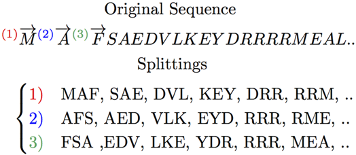

(5) Divide data into splits for multivariate LSTM time-series prediction, where m time steps are used as the input and n time steps are the output that is being predicted. 

In [7]:
### Preprocessing Part 2 ###

# Import embeddings CSV and create embeddings dictionary
def setup_embeds(file_path):
  with open(file_path) as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    embeddings = {}
    for row in csv_reader:
      temp = (row[0].split('\t'))
      nums = temp[1:]
      nums = np.array([float(num) for num in nums])
      nums = nums.reshape((100, 1))
      embeddings[temp[0]] = nums
  return embeddings


embed_dict = setup_embeds("/content/drive/My Drive/mais_data/protVec_100d_3grams.csv")


# Create 3-gram splittings with overlap
def split_seq(sequence):
  # Take as input a sequence string and output splits as list 
  split_list = [] 
  for i in range(3):
    for j in range(0, len(sequence), 3):
      if j+i+3 <= len(sequence):
        split_list.append(sequence[j+i:j+i+3])
      # if len(sequence) - j < 3:
      #   split_list.append("end")
  return split_list


# Embed the protein
def embed(sequence, embed_dict):
  sequence_vec = np.zeros((100, 1))
  split_list = split_seq(sequence)
  for three_gram in split_list:
    vec_three_gram = embed_dict[three_gram]
    sequence_vec = sequence_vec + vec_three_gram
  return sequence_vec


def embed_site(sequence, site_position, embed_dict):
  # Create 3 3-gram embeddings for a specific target site on the sequence and sum
  site_vec = np.zeros((100, 1))
  three_grams = []
  for i in range(3):
    begin = site_position+i-2
    end = site_position+i
    three_gram = sequence[begin:end+1]
    three_grams.append(three_gram)
  for three_gram in three_grams:
    vec_three_gram = embed_dict[three_gram]
    site_vec += vec_three_gram
  return site_vec
    
# test_seq = "ABCDEFGHIJKLMN"
# test,vec = embed_site(test_seq, 4, embed_dict)

def embed_all_sites(sequence_list, site_positions):
  # Expect seq_by_month
  all_embedded = []
  for site_position in site_positions:
    embedded_months = []
    for month in sequence_list:
      month_embed = []
      for sequence in month:
        embedded_site = embed_site(str(sequence.seq), site_position, embed_dict)
        month_embed.append(embedded_site)
      embedded_months.append(month_embed)
    all_embedded.append(embedded_months)
  return all_embedded
      

def embed_seq_by_month(sequence_list):
  embedded_all = []
  for month in sequence_list:
    embedded_month = []
    for sequence in month:
      embedded_month.append(embed(sequence.seq, embed_dict))
    embedded_all.append(embedded_month)
  return embedded_all


# Embed all proteins in FASTA file and export as CSV
def embed_all(fasta_list, file_path):
  sequence_vecs = {}
  for seq_record in fasta_list:
    sequence = str(seq_record.seq)
    id = seq_record.id
    sequence_vec = embed(sequence, embed_dict)
    sequence_vecs[id] = sequence_vec

  with open(file_path, "w") as csv_file:
    writer = csv.writer(csv_file)
    for key, value in sequence_vecs.items():
      writer.writerow([key, value])

  return sequence_vecs


# data_vecs = embed_all(data3, '/content/drive/My Drive/mais_data/November 24/global_vectors.csv')


In [105]:
embedded_221 = embed_all_sites(seq_by_month, [221])
# encoded_221, embedded_221

In [58]:
print(test)
print(test_seq[4])
print(vec.shape)

['CDE', 'DEF', 'EFG']
E
(100, 1)


12
12


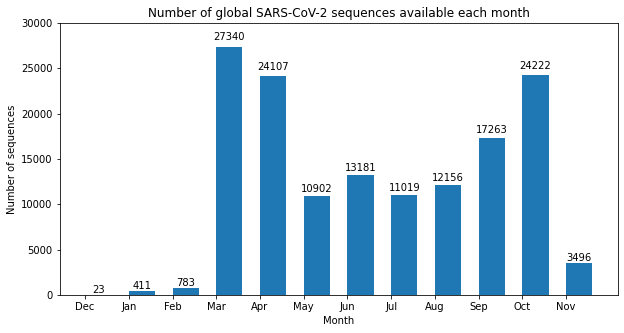

In [ ]:
# Data distribution
dates = []
counter = 0 
for key in data_vecs:
  id = str(key)
  match = re.search(r'\d{4}-\d{2}-\d{2}', id)
  date = datetime.strptime(match.group(), '%Y-%m-%d')
  dates.append(date)

months = [date.month for date in dates]
tests = [date for date in dates if date.month == 11]
frequencies = Counter(months)

# x = [i+1 for i in range(12)]
x = ["Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov"]
print(len(x))
y = [frequencies[month] for month in frequencies]
print(len(y))

plt.figure(figsize=(10, 5))
bar_plot = plt.bar(x, y, align='edge', width=0.6)
axes = plt.gca()
axes.set_ylim([0, 30000])
plt.xlabel('Month')
plt.ylabel('Number of sequences')
plt.title('Number of global SARS-CoV-2 sequences available each month')

for idx, rect in enumerate(bar_plot):
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width()/2., 1.02 * height,
          y[idx],
          ha='center', va='bottom', rotation=0)


In [ ]:
for i in range(11):
  print(len(seq_by_month[i]))

23
411
783
27340
24107
10902
13181
11019
12156
17263
24222


## Make dataset

Randomly select sequences from each month and link to create a single sample for training



In [9]:
# Label encoding
# def label_encode(sequence_list):
#   amino_acids = ['A', 'F', 'Q', 'R', 'T', 'Y', 'V', 'I', 'H', 'K', 'P', 'N', 'E', 'G', 'S', 'M', 'D', 'W', 'C', 'L', 'B', 'J', 'Z']
#   le = preprocessing.LabelEncoder()
#   le.fit(amino_acids)

#   all_encoded_seqs = []
#   for sequence in sequence_list:

# Embed everything in seq_by_month
# embedded_all = embed_seq_by_month(seq_by_month)
import random

def link_train(embedded, encoded, num_samples):
  # Link December to September, predict October
  # Expecting a list of sublists, where each sublist is the ProtVec sequences in a particular month
  # Link embedded_all at the same time as encoded
  samples_emb = []
  samples_enc = []
  for i in range(num_samples):
    month_enc_samples = []  # One linked list sample
    month_emb_samples = []
    for j in range(len(embedded) - 1): # len(embedded) = len(encoded) = num months
      num_seq = len(embedded[j]) # equivalent here too
      rand_int = random.randint(0, num_seq-1) # inclusive, so subtract 1
      month_enc_samples.append(encoded[j][rand_int])
      month_emb_samples.append(embedded[j][rand_int])
    samples_emb.append(month_emb_samples)
    samples_enc.append(month_enc_samples)
  return samples_emb, samples_enc

def link_test(embedded, encoded, num_samples):
  # Link January to October, predict November
  # Expecting a list of sublists, where each sublist is the ProtVec sequences in a particular month
  # Link embedded at the same time as encoded
  samples_emb = []
  samples_enc = []
  for i in range(num_samples):
    month_enc_samples = []  # One linked list sample
    month_emb_samples = []
    for j in range(1, len(embedded)): # len(embedded) = len(encoded)
      num_seq = len(embedded[j]) # equivalent here too
      rand_int = random.randint(0, num_seq-1) # inclusive, so subtract 1
      month_enc_samples.append(encoded[j][rand_int])
      month_emb_samples.append(embedded[j][rand_int])
    samples_emb.append(month_emb_samples)
    samples_enc.append(month_enc_samples)
  return samples_emb, samples_enc

def separate_data(data):
  # Expect list of months with sequence data in each month
  train = []
  test = []
  for month in data:
    train.append(month[0:math.floor(0.7*len(month))])
    test.append(month[math.floor(0.7*len(month)):])
  return train, test

In [ ]:
embedded_all = embed_seq_by_month(seq_by_month) # Length of embedded_all should be 12

In [ ]:
import pickle

with open('/content/drive/MyDrive/mais_data/November 24/seq_by_month.data', 'wb') as filehandle:
  pickle.dump(seq_by_month, filehandle)

with open('/content/drive/MyDrive/mais_data/November 24/encoded_sequences.data', 'wb') as filehandle:
  pickle.dump(encoded_sequences, filehandle)

with open('/content/drive/MyDrive/mais_data/November 24/embedded_all.data', 'wb') as filehandle:
  pickle.dump(embedded_all, filehandle)

In [102]:
with open('/content/drive/MyDrive/mais_data/November 24/seq_by_month.data', 'rb') as filehandle:
  seq_by_month = pickle.load(filehandle)

with open('/content/drive/MyDrive/mais_data/November 24/encoded_sequences.data', 'rb') as filehandle:
  encoded_sequences = pickle.load(filehandle)

with open('/content/drive/MyDrive/mais_data/November 24/embedded_all.data', 'rb') as filehandle:
  embedded_all = pickle.load(filehandle)

In [65]:
print(seq_by_month[0][0].seq)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
# Separated data, but not yet linked
embed_train, embed_test = separate_data(embedded_all)
encode_train, encode_test = separate_data(encoded_sequences)

In [107]:
# Separated site data, but not yet linked
embed221_train, embed221_test = separate_data(embedded_221[0])
encode221_train, encode221_test = separate_data(encoded_221)

In [83]:
# Linked train and test sets
train_embed, train_encode = link_train(embed_train, encode_train, 50000)
test_embed, test_encode = link_test(embed_test, encode_test, 5000)

In [113]:
# Linked train and test sets for site 221
train221_embed, train221_encode = link_train(embed221_train, encode221_train, 100000)
test221_embed, test221_encode = link_test(embed221_test, encode221_test, 10000)

In [115]:
# Exclude the embeddings for the last month in each linked list to make the final training dataset
X_train = []
for i in range(len(train_embed)):
  X_train.append(train_embed[i][0:-1])  # Everything except October

X_test = []
for j in range(len(test_embed)):
  X_test.append(test_embed[j][0:-1])  # Everything except November


In [116]:
# Exclude the embeddings for the last month in each linked list to make the final training dataset - site 221
X221_train = []
for i in range(len(train221_embed)):
  X221_train.append(train221_embed[i][0:-1])  # Everything except October

X221_test = []
for j in range(len(test221_embed)):
  X221_test.append(test221_embed[j][0:-1])  # Everything except November

In [117]:
X_train = np.array(X_train).reshape(50000, 10, 100)
X_test = np.array(X_test).reshape(5000, 10, 100)

In [118]:
X221_train = np.array(X221_train).reshape(100000, 10, 100)
X221_test = np.array(X221_test).reshape(10000, 10, 100)

In [119]:
print(X221_train.shape)  # (number of samples, time steps, features/dimension of ProtVec)

(100000, 10, 100)


In [120]:
print(X221_test.shape)

(10000, 10, 100)


In [121]:
# Make labels by comparing penultimate with last sequences
# Requires linked categorical dataset

def make_labels(linked_enc):
  # Returns list of numpy arrays that contains categorical labels for mutations at specific sites
  y = []
  for i in range(len(linked_enc)):
    labels = np.zeros(1273)
    last = linked_enc[i][10]
    penultimate = linked_enc[i][9]
    for j in range(len(last)):
      if last[j] != penultimate[j]:
        labels[j] = 1
    y.append(labels)
  return y

def make_site_labels(linked_enc):
# Returns list of numpy arrays that contains categorical labels for mutations at one specific site
  y = []
  for i in range(len(linked_enc)):
    label = 0
    last = linked_enc[i][10]
    penultimate = linked_enc[i][9]
    if last != penultimate:
      label += 1
    y.append(label)
  return y

In [155]:
print(train221_encode[12345][9])

[0]


In [90]:
y_train = make_labels(train_encode)  # Same order as embedded_samples
y_test = make_labels(test_encode)

In [122]:
y221_train = make_site_labels(train221_encode)  # Same order as embedded_samples
y221_test = make_site_labels(test221_encode)

In [91]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [123]:
y221_train = np.array(y221_train)
y221_test = np.array(y221_test)

In [125]:
print(y221_train.shape)

(100000,)


In [30]:
print(np.count_nonzero(y221_train==0))
print(np.count_nonzero(y221_train==1))
# Pretty even distribution of the number of times mutation 221 appears.

23995
26005


In [ ]:
# Finding the item in the list which produced the max mutations 
train_sum = np.sum(y_train, axis=1)
max_ind = np.argmax(train_sum)  # argmin, sometimes there is no mutations too
most_mutations = train_sum[max_ind]
print(most_mutations)

# Finding the average number of mutations for the training data
average_mutations = np.sum(train_sum)/len(y_train)
print(average_mutations)


In [93]:
# Find the mutation distribution of the data 
mutation_vec = np.zeros(1273)
no_mutations = 0

for i in range(50000):
  label = y_train[i]
  if np.sum(label) == 0:
    no_mutations += 1
  else:
    for j in range(len(label)):
      if label[j] == 1:
        mutation_vec[j] += 1
      else:
        continue


In [20]:
mutation_221 = 0
for i in range(300000):
  label = y_train[i]
  if label[221] == 1 and np.sum(label) == 1:
    mutation_221 += 1

mutation_221_3 = 0
for i in range(300000):
  label = y_train[i]
  if label[221] == 1 and np.sum(label) == 3:
    mutation_221_3 += 1


Text(0.5, 1.0, 'Mutation frequency for sequence sites between September and October')

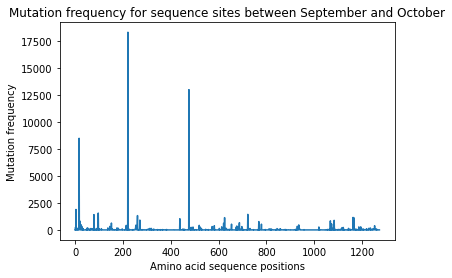

In [94]:
plt.plot(mutation_vec)
plt.xlabel('Amino acid sequence positions')
plt.ylabel('Mutation frequency')
plt.title('Mutation frequency for sequence sites between September and October')

In [ ]:
print(np.argmax(train_sum))
print(train_encode[max_ind][9])
print(train_encode[max_ind][10])

test1 = train_encode[max_ind][9]
test2 = train_encode[max_ind][10]

labels = np.zeros(1273)

for i in range(len(test1)):
  if test1[i] != test2[i]:
    print((test1[i], test2[i], i))
    labels[i] = 1

print(np.where(labels == 1))

191084
[12  5 19 ...  7 21 18]
[12  5 19 ...  7 21 18]
(11, 14, 8)
(11, 5, 17)
(10, 8, 149)
(18, 8, 209)
(0, 19, 221)
(2, 21, 265)
(11, 14, 383)
(10, 4, 483)
(14, 17, 811)
(array([  8,  17, 149, 209, 221, 265, 383, 483, 811]),)


In [124]:
print(y_train.shape)  # (number of samples, dimension of labels)

(50000, 1273)


In [ ]:
print(y_test.shape)

In [ ]:
# Sanity checks
# print(test_encode[0][8][0])
# print(test_encode[0][9][0])
test1 = test_encode[0][8]
test2 = test_encode[0][9]

labels = np.zeros(1273)

for i in range(len(test1)):
  if test1[i] != test2[i]:
    print((test1[i], test2[i], i))
    labels[i] = 1

print(np.where(labels == 1))

In [ ]:
print(np.where(y_test[0]==1))

# Model

In [95]:
pip install keras-self-attention

In [126]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.layers import Layer
# from keras_self_attention import SeqWeightedAttention
import keras.backend as K

import h5py

In [127]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

In [ ]:
class attention(Layer):
    def __init__(self, units, output_dim):
      self.units = units
      self.output_dim = output_dim

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [27]:
print(X221_train.shape)

(50000, 10, 100)


In [133]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
]

model = keras.Sequential()
model.add(layers.LSTM(units=128, return_sequences=True, input_shape=(X221_train.shape[1], X221_train.shape[2])))
model.add(layers.LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=[METRICS, 'accuracy'])
# model.add(layers.LSTM(units=128))

# Stacked LSTM
# def evaluate_model(X_train, y_train, X_test, y_test)
  # Evaluate single model
# model.add(layers.LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(layers.LSTM(units=128, return_sequences=True))
# model.add(layers.LSTM(units=128, return_sequences=True))
# model.add(layers.LSTM(units=128))
# model.add(Dropout(0.2))
# model.add(Dense(units=512, activation='relu'))
# model.add(Dense(units=256, activation='relu'))

# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0001))
# model.fit(X_train, y_train,
#   epochs=85,
#   batch_size=16,
#   validation_split=0.1,
#   verbose=1,
#   shuffle=False,
#   callbacks=callbacks_list
#   )
  # model.summary()

# Checkpointing
filepath="weights-improvement-trial-randomstate_7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list += [lr_reduction]


# Attention model

# model = keras.Sequential()

# model.add(layers.LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(layers.LSTM(units=128, return_sequences=True))
# model.add(SeqWeightedAttention())
# model.add(Dropout(0.2))
# model.add(Dense(units=1273,activation='sigmoid'))
# model.summary()

# model.add(Dropout(0.2))
# model.add(keras.layers.Dense(units=1273))

In [134]:
history = model.fit(
    X221_train, y221_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    # class_weight = class_weight,
    verbose=1,
    shuffle=False,
    callbacks=callbacks_list
    )

Epoch 1/50
2499/2500 [============================>.] - ETA: 0s - loss: 6.1431e-08 - tp: 14847.0000 - fp: 13773.0000 - tn: 24986.0000 - fn: 26362.0000 - precision: 0.5188 - recall: 0.3603 - accuracy: 0.4981
Epoch 00001: val_accuracy improved from -inf to 0.47995, saving model to weights-improvement-trial-randomstate_7.hdf5
2500/2500 [==============================] - 85s 34ms/step - loss: 6.1426e-08 - tp: 14849.0000 - fp: 13778.0000 - tn: 25000.0000 - fn: 26373.0000 - precision: 0.5187 - recall: 0.3602 - accuracy: 0.4981 - val_loss: 6.2001e-08 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 9598.0000 - val_fn: 10401.0000 - val_precision: 1.0000 - val_recall: 9.6135e-05 - val_accuracy: 0.4800
Epoch 2/50
2499/2500 [============================>.] - ETA: 0s - loss: 6.1431e-08 - tp: 15022.0000 - fp: 13857.0000 - tn: 24902.0000 - fn: 26187.0000 - precision: 0.5202 - recall: 0.3645 - accuracy: 0.4992
Epoch 00002: val_accuracy did not improve from 0.47995
2500/2500 [==========================

In [181]:
print(lr_X_train[0][:].shape)

(100,)


In [57]:
lr_X_train = X221_train[:, 9, :]

model_lr = keras.Sequential()
model_lr.add(Dense(1, input_shape=(100,), activation='sigmoid'))
model_lr.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [75]:
model_nn = keras.Sequential()
model_nn.add(Dense(64, input_shape=(100,), activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

filepath="weights-improvement-trial-randomstate_7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list += [lr_reduction]

histroy2=model_nn.fit(
    x=lr_X_train,
    y=y221_train,
    shuffle=True,
    epochs=15,
    batch_size=32,
    callbacks=callbacks_list
)

Epoch 1/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6915 - binary_accuracy: 0.5306
Epoch 2/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6914 - binary_accuracy: 0.5311
Epoch 3/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5315
Epoch 4/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5317
Epoch 5/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6912 - binary_accuracy: 0.5317
Epoch 6/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6914 - binary_accuracy: 0.5316
Epoch 7/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5317
Epoch 8/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5317
Epoch 9/15
1563/1563 [==============================] - 4s 3ms/step - loss: 0.6912 - binary_accuracy: 0.5316
Epoch 10/15
1563/15

In [59]:
history1=model_lr.fit(
    x=lr_X_train,
    y=y221_train,
    shuffle=False,
    epochs=15,
    batch_size=1,
    callbacks=callbacks_list
)

Epoch 1/15
50000/50000 [==============================] - 44s 884us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 2/15
50000/50000 [==============================] - 41s 817us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 3/15
50000/50000 [==============================] - 40s 806us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 4/15
50000/50000 [==============================] - 42s 831us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 5/15
50000/50000 [==============================] - 39s 775us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 6/15
50000/50000 [==============================] - 37s 742us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 7/15
50000/50000 [==============================] - 41s 824us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 8/15
50000/50000 [==============================] - 39s 780us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 9/15
50000/50000 [==============================] - 40s 790us/step - loss: 0.6932 

In [41]:
print(lr_X_train.shape)

(50000, 100)


[[5.686e-01 1.000e-04]
 [4.310e-01 3.000e-04]]


[Text(19.699999999999996, 0.5, 'Actual value'),
 Text(0.5, 44.24, 'Predicted value')]

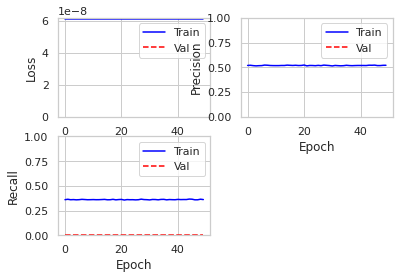

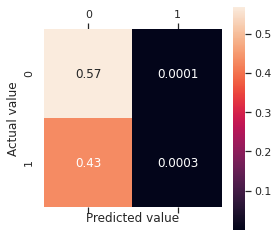

In [188]:
from sklearn.metrics import confusion_matrix
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='red', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)
confusionmatrix = confusion_matrix(y221_test, y_pred.reshape(10000), normalize='all')
plt.matshow(confusionmatrix)
print(confusionmatrix)

import seaborn as sns

ax = sns.heatmap(confusionmatrix, annot=True)
ax.set(xlabel="Predicted value", ylabel="Actual value")

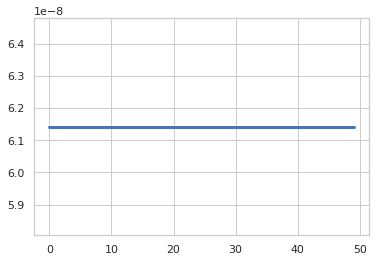

In [187]:
sns.set_theme(style='whitegrid')
data = [history.history['loss'], history]
sns.lineplot(data=history.history["loss"], linewidth=3)

In [166]:
print(y_pred.shape)

(10000, 1)


In [ ]:
print(y_train.shape)

(500000, 1273)


In [147]:
y_pred = model.predict(X221_test)

In [30]:
print(y_pred[0])
print(y_pred[0][17], y_pred[0][255])
print(np.where(y_test[0]==1))

[3.4356183e-28 1.6182065e-03 1.0000000e+00 ... 1.4738523e-28 3.3156663e-02
 4.1974992e-02]
1.0 1.0
(array([261, 271]),)


In [148]:
thresh = 0.5
for i in range(len(y_pred)):
  up = y_pred[i] >= 0.5
  down = y_pred[i] < 0.5
  y_pred[i][up] = 1
  y_pred[i][down] = 0


In [151]:
print(np.where(y_pred==1))

(array([4437, 5307, 7105, 7801]), array([0, 0, 0, 0]))


In [153]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y221_test, y_pred)
print(accuracy)

0.5689


In [157]:
print(np.count_nonzero(y221_test==0))
print(np.count_nonzero(y221_test==1))

5687
4313


In [ ]:
# First run: 48.660% validation accuracy
# Second run: 60.4% validation accuracy
# Third run: 60.7% test accuracy

# Don't mind anything below here

In [ ]:
# # Cluster sequences
# # Put data in pandas dataframe
# prot_vecs = pd.read_csv('/content/drive/My Drive/mais_data/November 24/global_vectors.csv', names=["ID", "Protein vector"])

# for i in range(len(prot_vecs)):
#   temp = prot_vecs["ID"][i]
#   match = re.search(r'\d{4}-\d{2}-\d{2}', temp)
#   date = datetime.strptime(match.group(), '%Y-%m-%d')
#   prot_vecs["ID"][i] = date.month

#   temp = prot_vecs["Protein vector"][i]
#   ls = re.sub('\n', ',', temp)
#   converted = np.array(ast.literal_eval(ls))
#   prot_vecs["Protein vector"][i] = converted


In [ ]:
# march = prot_vecs.loc[prot_vecs['ID'] == 3].reset_index()
# vecs = []
# for i in range(len(march)):
#   vecs.append(march["Protein vector"][i])

# print(len(vecs))

# train = np.array([vec for vec in prot_vecs["Protein vector"]])
# print(train.shape)
# train = train.reshape(len(train), 100)

# min_samples = math.floor(len(train)*0.01)
# clf = cluster.DBSCAN(eps=3, min_samples=min_samples, metric='euclidean')
# clf.fit(train)
# labels=clf.labels_
# centroids = neighbors.NearestCentroid().fit(train, labels).centroids_

27340
(144903, 100, 1)


In [189]:
# vecs = train
# pca = decomposition.PCA(n_components=3)
# reduced_data = pca.fit_transform(vecs)
# # reduced_centroids = NearestCentroid().fit(reduced_data, labels).centroids_



In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # for i in range(len(reduced_data)):
# #   colors = 10 * ['r.', 'g.', 'y.', 'c.', 'm.', 'b.', 'k.']
# #   plt.plot(reduced_data[i][0], reduced_data[i][1], colors[labels[i]], markersize=10)

# for i in range(len(reduced_data)):
#   colors = 10 * ['r.', 'g.', 'y.', 'c.', 'm.', 'b.', 'k.']
#   ax.scatter(reduced_data[i][0], reduced_data[i][1], reduced_data[i][2], 
#              colors[labels[i]], marker='.', zorder=1)

In [ ]:
 def sort_by_month(seq_list):
  # Take raw list of sequences and split by months
  split_months = []
  for i in range(11):
    month_list = []
    if i == 0:  # Account for December 2019
      month_to_search = 12
    else:
      month_to_search = i+1
    for sequence in seq_list:
      id = str(sequence.id)
      match = re.search(r'\d{4}-\d{2}-\d{2}', id)
      date = datetime.strptime(match.group(), '%Y-%m-%d')
      if date.month == month_to_search:
        month_list.append(sequence)
    split_months.append(month_list)

  return split_months

def encode_seq(seq_by_month):
  # Take list of sequences already split by month and encode amino acids
  amino_acids = ['A', 'F', 'Q', 'R', 'T', 'Y', 'V', 'I', 'H', 'K', 'P', 'N',
                 'E', 'G', 'S', 'M', 'D', 'W', 'C', 'L', 'B', 'J', 'Z']
  le = preprocessing.LabelEncoder()  # Encodes in alphabetical order
  le.fit(amino_acids)

  encoded_seqs = []
  for month_seqs in seq_by_month:
    month_encoded_seqs = []
    for sequence in month_seqs:
      AA_chars = list(str(sequence.seq))
      month_encoded_seqs.append(le.transform(AA_chars))

    encoded_seqs.append(month_encoded_seqs)

  return encoded_seqs


### Protein embedding ###

def setup_embeds(file_path):
  # Import embeddings CSV and create embeddings dictionary
  with open(file_path) as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    embeddings = {}
    for row in csv_reader:
      temp = (row[0].split('\t'))
      nums = temp[1:]
      nums = np.array([float(num) for num in nums])
      nums = nums.reshape((100, 1))
      embeddings[temp[0]] = nums
  return embeddings


def split_seq(sequence):
  # Create 3-gram splittings with overlap
  # Take as input a sequence string and output splits as list 
  split_list = [] 
  for i in range(3):
    for j in range(0, len(sequence), 3):
      if j+i+3 <= len(sequence):
        split_list.append(sequence[j+i:j+i+3])
      # if len(sequence) - j < 3:
      #   split_list.append("end")
  return split_list


def embed(sequence, embed_dict):
  # Embed a single protein sequence
  sequence_vec = np.zeros((100, 1))
  split_list = split_seq(sequence)
  for three_gram in split_list:
    vec_three_gram = embed_dict[three_gram]
    sequence_vec = sequence_vec + vec_three_gram
  average = sequence_vec 
  return sequence_vec


def embed_by_month(sequence_list)
  # Embed a list of sequences that are ALREADY split by month
  month_prot_vecs = []
  for month_seqs in seq_by_month:
    vecs = []
    for sequence in month_seqs:
      vecs.append(embed(sequence, embed_dict))
    month_prot_vecs.append(vecs)
  return month_prot_vecs

def embed_all(fasta_list, file_path):
  # Embed all proteins in FASTA file and export as CSV
  sequence_vecs = {}
  for seq_record in fasta_list:
    sequence = str(seq_record.seq)
    id = seq_record.id
    sequence_vec = embed(sequence, embed_dict)
    sequence_vecs[id] = sequence_vec

  with open(file_path, "w") as csv_file:
    writer = csv.writer(csv_file)
    for key, value in sequence_vecs.items():
      writer.writerow([key, value])

  return sequence_vecs

In [ ]:
# Initiate embedding dictionary
embed_dict = setup_embeds("/content/drive/My Drive/mais_data/protVec_100d_3grams.csv")
# data_vecs = embed_all(data3, '/content/drive/My Drive/mais_data/November 24/global_vectors.csv')

# Split sequences by month, ordered temporally (indices: dec = 0, jan = 1, etc.)
seq_by_month = sort_by_month(data3)

# Embed seq_by_month sequences into protein vector representations
prot_vecs = embed_by_month(seq_by_month)

# Encode seq_by_month sequences into numbers
encoded_sequences = encode_seq(seq_by_month)

In [ ]:
### Cluster linking ### 

def cluster_months(prot_vecs):
  # KMeans clustering, cluster sequences in each month
  # Append month clusters to list as dictionary with data, label, and centroid info
  clusters = []
  for month_prot_vecs in prot_vecs:
    clf = KMeans(n_clusters=3)
    clf.fit(year_prot_vecs)
    labels = clf.labels_
    centroids = clf.cluster_centers_

    clusters.append({'data':month_prot_vecs, 'labels':labels,
                     'centroids:' centroids})  # Each label represents one cluster
    return clusters

  # prot_vecs.loc[prot_vecs['ID'] == i]

clusters = cluster_months(prot_vecs)

def remove_outliers(data, clusters):
    for month_idx, cluster in enumerate(clusters):
        idxs_to_remove = []
        for i, label in enumerate(cluster['labels']):
            if(label == -1): idxs_to_remove.append(i) # -1 means outlier
        data[month_idx] = [prot_vec for i, prot_vec in enumerate(data[month_idx]) if i not in idxs_to_remove]
        clusters[month_idx]['labels'] = [label for i, label in enumerate(cluster['labels']) if i not in idxs_to_remove]
        clusters[month_idx]['data'] = [strain for i, strain in enumerate(cluster['data']) if i not in idxs_to_remove]
        if -1 in clusters[month_idx]['population']: del clusters[month_idx]['population'][-1]

    return data, clusters


def silhouette_evaluate(clusters):
  # Calculate silhouette score and evaluate clusters
  scores = []
  for cluster in clusters:
    score = silhouette_score(cluster['data'], cluster['labels'])
    scores.append(score)

    average = sum(scores) / float(len(scores))
    return average

evaluation = silhouette_evaluate(clusters)  # [-1, 1], 1 is optimal
print(evaluation)

def link_clusters(clusters):
  # Determine 2 closest clusters and create links between clusters in different months
  num_months = len(clusters)  # Number of cluster dictionaries
  neigh = NearestNeighbors(n_neighbors=2)

  for month_idx in range(num_months):
    if (month_idx == no_years-1):  # Cannot link last year,  
      clusters[month_idx]['links'] = []
      break
    
    links = []  # If not penultimate month, then append links as new item in dictionary
    current_centroids = cluster[month_idx]['centroids']
    next_month_centroids = clusters[month_idx + 1]['centroids']
    neigh.fit(next_month_centroids)

    idxs_by_centroid = neigh.kneighbors(current_centroids, return_distance=False)

    for label in clusters[month_idx]['labels']:
      if (idxs_by_centroid[label][0] == -1): del idxs_by_centroid[label][0]
      links.append(idxs_by_centroid(label))  # Centroid index corresponds to label

    clusters[month_idx]['links'] = links  # Append labels linking to closest next month clusters

  return clusters

linked_clusters = link_clusters(clusters)

def label_encode(seq_by_month):
  # Categorical encoding ordered alphabetically
  amino_acids = ['A', 'F', 'Q', 'R', 'T', 'Y', 'V', 'I', 'H', 'K', 'P', 'N',
                 'E', 'G', 'S', 'M', 'D', 'W', 'C', 'L', 'B', 'J', 'Z']
  le = preprocessing.LabelEncoder()  # Encodes in alphabetical order
  le.fit(amino_acids)

  encoded_seqs = []
  for month_seqs in seq_by_month:
    month_encoded_seqs = []
    for sequence in month_seqs:
      AA_chars = list(str(sequence.seq))
      month_encoded_seqs.append(le.transform(AA_chars))

    encoded_seqs.append(month_encoded_seqs)

  return encoded_seqs


def cluster_raw(strains_by_month):
  clusters = []
  for month_idx, month_strains in enumerate(strains_by_month):
    min_samples = math.floor(len(year_strains)*0.05)
    clf = DBSCAN(eps=0.07, min_samples=min_samples,
                 metric='hamming').fit(month_strains)
    labels = clf.labels_

    unique, count = np.unique(labels, return_counts=True)

    cluster = {
        'data': year_strains, 
        'labels': labels, 
        'population': dict(zip(unique, count))
    }

    clusters.append(cluster)
  return clusters



def sample_from_clusters(strains_by_month, clusters_by_month, sample_size, verbose=False):
  # Take input from cluster_raw function
  
  sampled_strains = [[]] * len(strains_by_month)

  # Start sample from the first cluster, aka first month
  first_month_labels = clusters_by_month[0]['labels']
  first_month_population = clusters_by_month[0]['population']
  first_month_total = len(strains_by_month[0])

  for label_idx in first_month_population.keys():  # len(population) = num_clusters
    cluster_proportion = first_month_population[label_idx]/first_month_total
    cluster_sample_size = math.floor(sample_size*cluster_proportion)
    cluster_strains = [strains_by_month[0][i]] for i, label 
                    in enumerate(first_month_labels) if label == label_idx]
    sampled_strains[0] = sampled_strains[0] + random.choices(cluster_strains, k=cluster_sample_size)

    # On the last iteration sample missing
    missing_samples = sample_size - len(sampled_strains[0])
    if label_idx == list(first_year_population)[-1] and missing_samples > 0:
      print(f'Missing samples: {missing_samples}')
      sampled_strains[0] = sampled_strains[0] + random.choices(cluster_strains, k=missing_samples)


  # Sample forward
  current_cluster = label_encode([sampled_strains[0]])[0]
  for month_idx in range(1, len(clusters_by_month)):
    month_clusters = clusters_by_month[month_idx]

    if(verbose): 
          print(f'\n>>> Linking {month_idx} year')
          print(f'Clusters\n{month_clusters["population"]}')

    neigh = NearestNeighbors(n_neighbors=1, metric='hamming') # Closest 1 neighbour
    neigh.fit(year_clusters['data'])
    neighbour_strain_idx = neigh.kneighbors(current_cluster, return_distance=True)

    nice_neighs = [idx[0] for idx in neighbour_strain_idx[1]]
    links = [month_clusters['labels'][idx] for idx in nice_neighs]

    if (verbose):
      validation.list_summary('Neighbours', nice_neighs)
      validation.list_summary('Links', links)

    clustered_strains = {}
    for label_idx in year_clusters['population'].keys():
      clustered_strains[label_idx] = [strains_by_year[month_idx][i] for i, label
                                      in enumerate(year_clusters['labels']) if label == label_idx]

    for link in links:
      sample = random.choice(clustered_strains[link])
      sampled_strains[month_idx] = sampled_strains[month_idx] + [sample]

  return sampled_strains

# Sample linked clusters
# Do this n times to build n training samples, which will be input to LSTM 

SyntaxError: ignored

# Make the dataset

In [ ]:
prot_vec_file = '/content/drive/My Drive/mais_data/protVec_100d_3grams.csv'

def read_trigram_vecs(prot_vec_file):  # Path to 3gram prot vecs
  """
  Reads the csv file containing 100 dimensional prot vecs, the 
  data_path argument indicating where it is located.
  Returns a dictionary that maps a 3gram of amino acids to its
  index and a numpy array containing the trigram vecs.
  """
    
  df = pd.read_csv(prot_vec_file, delimiter = '\t')
  trigrams = list(df['words'])
  trigram_to_idx = {trigram: i for i, trigram in enumerate(trigrams)}
  trigram_vecs = df.loc[:, df.columns != 'words'].values
  
  return trigram_to_idx, trigram_vecs


def read_strains_from(clean_path):  # Read cleaned raw sequences 
  """
  Reads the raw strains from the data_files located by the data_path.
  Returns a pandas series for each data file, contained in a ordered list.
  """
  #_, data_path = subtype_selection(subtype)
  raw_strains = []
  df = pd.read_csv(clean_path)
  raw_strains.append(df)
    
  return raw_strains


def train_test_split_strains(strains_by_month, test_split, cluster):
  """
  Shuffles the strains in each year and splits them into two disjoint sets,
  of size indicated by the test_split.
  Expects and returns pandas dataframe or series.
  """
  train_strains, test_strains = [], []
  if cluster == 'random':
      for strains in strains_by_year:
          num_of_training_examples = int(math.floor(strains.count() * (1 - test_split)))
          shuffled_strains = strains.sample(frac=1).reset_index(drop=True)
          train = shuffled_strains.iloc[:num_of_training_examples].reset_index(drop=True)
          test = shuffled_strains.iloc[num_of_training_examples:].reset_index(drop=True)
          train_strains.append(train)
          test_strains.append(test)
  else:
      #change the starting index for the time-series training samples for multiple experiments
      for strains in strains_by_year:
          num_of_training_examples = int(math.floor(strains.count() * (1 - test_split)))
          train = strains.iloc[:800].reset_index(drop=True)
          test = strains.iloc[800:1000].reset_index(drop=True)
          train_strains.append(train)
          test_strains.append(test)
  return train_strains, test_strains


def read_clusters_from(data_files, start_clusters=[0], no_clusters=1,  method='DBSCAN', data_path='../data/interim/'):
  """Reads in data and picks linked clusters"""
  raw_strains = []
  clusters_to_pick = start_clusters
  for file_name in data_files:
    df = pd.read_csv(data_path + method + '.' + file_name)
    df = df[df.cluster.isin(clusters_to_pick)]

    next_year_clusters = []
    for cluster in clusters_to_pick:
        string_list = df[df['cluster'] == cluster]['links'].iloc[0][1:-1].split(' ')
        next_year_clusters += [int(i) for i in string_list]
    clusters_to_pick = next_year_clusters[:no_clusters]
        
    uncertain_strains = df['seq']
    sequences = replace_uncertain_AAs(uncertain_strains)
    raw_strains.append(sequences)

  return raw_strains

##**Preprocessing Part 3**

Finally, we need to split the data. 

In [ ]:
# class RnnModel(nn.Module):
#   def __init__(self, input_dim, output_dim, hidden_size, dropout_p, cell_type):
#     super(RnnModel, self).__init__()

#     self.output_dim = output_dim
#     self.hidden_size = hidden_size
#     self.cell_type = cell_type

#     self.dropout = nn.Dropout(dropout_p)

#     if cell_type == 'LSTM'L
#       self.encoder = nn.LSTM(input_dim, hidden_size)
    
#     self.out == nn.Linear(hidden_size, output_dim)
  
#   def forward(self, input_seq, hidden_state):
#     input_seq = self.dropout(input_seq)
#     encoder_outputs, _ = self.encoder(input_seq, hidden_state)
#     score_seq = self.out(encoder_outputs[1,:,:])

In [ ]:
# import torch
# from torch import nn

# class LSTMModel(nn.Module):
#   def __init__(self, data):
#     super(Model, self).__init__()
#     self.lstm_size = 

In [ ]:
# Testing
test1 = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
test2 = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"

for j in range(24900, 25000):
  check = data3[j]
  print(j)
  for i in range(len(test1)):
    if test1[i] != check[i]:
      print((test1[i], check[i], i))
